<a href="https://colab.research.google.com/github/Caumel/TFG_Software/blob/master/Ejemplo%20redes%20siamesas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Siamesas

## Elementos auxiliares

### Importar los módulos necesarios

In [0]:
"""
A Siamese network example modified to use weighted L1 distance and cross-entropy loss, as in
Siamese Neural Networks for One-shot Image Recognition
http://www.cs.toronto.edu/~rsalakhu/papers/oneshot1.pdf
"""


import random
import numpy as np

from __future__ import absolute_import
from __future__ import print_function

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.optimizers import SGD, RMSprop
from keras import backend as K

from sklearn.metrics import accuracy_score as accuracy

Using TensorFlow backend.


### Distancia L1 punto a punto entre dos vectores

In [0]:
def get_abs_diff(vects):
    # L1 distance between two vectors
    x, y = vects
    return K.abs(x - y)

### ¿¿¿¿¿¿¿¿¿¿ Qué es esto ? ¿Quien lo invoca y para qué? ??????????

In [0]:
  

def abs_diff_output_shape(shapes):
    shape1, shape2 = shapes
    return shape1 

### Función para crear Pares de ejemplos positivos y negativos a partir del conjunto de entrenamiento

In [0]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

### Crear la red neuronal *base*

In [0]:
def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(128, input_shape=(input_dim,), activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    return seq

#

## MAIN

###   Inicializaciones, descarga de datos y reescalado a [0,1]



In [0]:
np.random.seed(2018) ##- for reproducibility
input_dim = 784
nb_epoch = 5

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, input_dim)
X_test = X_test.reshape(10000, input_dim)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

11493376/11490434 [==============================] - 0s 0us/step


### Crear conjuntos etiquetados de entrenamiento y test

In [0]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)] #El cero es para que te haga un array de 10 posiciones y cada una de tamaño X
print(digit_indices)
tr_pairs, tr_y = create_pairs(X_train, digit_indices)
print(tr_y)
digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, digit_indices)


[array([    1,    21,    34, ..., 59952, 59972, 59987]), array([    3,     6,     8, ..., 59979, 59984, 59994]), array([    5,    16,    25, ..., 59983, 59985, 59991]), array([    7,    10,    12, ..., 59978, 59980, 59996]), array([    2,     9,    20, ..., 59943, 59951, 59975]), array([    0,    11,    35, ..., 59968, 59993, 59997]), array([   13,    18,    32, ..., 59982, 59986, 59998]), array([   15,    29,    38, ..., 59963, 59977, 59988]), array([   17,    31,    41, ..., 59989, 59995, 59999]), array([    4,    19,    22, ..., 59973, 59990, 59992])]
[1 0 1 ... 0 1 0]


In [0]:

print(tr_pairs.shape)

(108400, 2, 784)


### Crear la red siamesa

In [0]:
# network definition
base_network = create_base_network(input_dim)

input_a = Input(shape=(input_dim,))   #Nos da un tensor del tamaño input_dim
input_b = Input(shape=(input_dim,))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)


abs_diff = Lambda(get_abs_diff, output_shape = abs_diff_output_shape)([processed_a, processed_b])

flattened_weighted_distance = Dense(1, activation = 'sigmoid')(abs_diff)

model = Model(input=[input_a, input_b], output = flattened_weighted_distance)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


### Entrenar

In [0]:
# train

rms = RMSprop()
model.compile(loss = 'binary_crossentropy', optimizer=rms, metrics = ['accuracy'])

a = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y),
          batch_size=128, nb_epoch=nb_epoch)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 108400 samples, validate on 17820 samples
Epoch 1/5
108400/108400 [==============================] - 8s 72us/step - loss: 0.3263 - acc: 0.8625 - val_loss: 0.2522 - val_acc: 0.9128
Epoch 2/5
108400/108400 [==============================] - 7s 64us/step - loss: 0.1811 - acc: 0.9327 - val_loss: 0.2425 - val_acc: 0.9193
Epoch 3/5
108400/108400 [==============================] - 7s 64us/step - loss: 0.1334 - acc: 0.9515 - val_loss: 0.1884 - val_acc: 0.9412
Epoch 4/5
108400/108400 [==============================] - 8s 72us/step - loss: 0.1108 - acc: 0.9603 - val_loss: 0.1265 - val_acc: 0.9617
Epoch 5/5
108400/108400 [==============================] - 8s 73us/step - loss: 0.0930 - acc: 0.9672 - val_loss: 0.1150 - val_acc: 0.9639


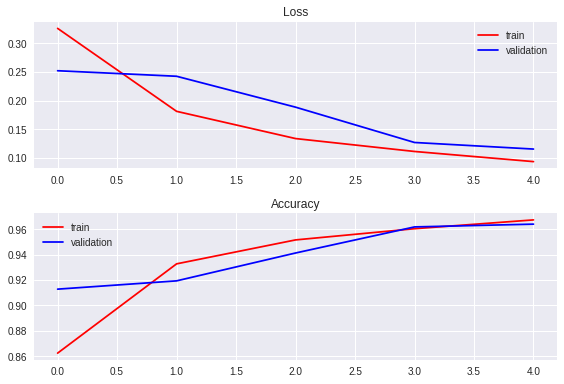

In [0]:
import matplotlib.pyplot as plt


plt.subplot(211)
plt.title("Loss")
plt.plot(a.history["loss"], color="r", label="train")
plt.plot(a.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Accuracy")
plt.plot(a.history["acc"], color="r", label="train")
plt.plot(a.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### Test

In [0]:
# test

# compute final accuracy on training and test sets
tr_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = accuracy(tr_y, tr_pred.round())

te_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = accuracy(te_y, te_pred.round())

print('* Accuracy on the training set: {:.2%}'.format(tr_acc))
print('* Accuracy on the test set: {:.2%}'.format(te_acc))



* Accuracy on the training set: 97.68%
* Accuracy on the test set: 96.39%
